# Course 4 - Project - Part 2: Data exploration

<a name="top-2"></a>
This notebook is concerned with *Part 2: Data exploration*.

**Contents:**
* [Step 0: Load data](#step-2.0)
* [Step 1: Plot a few images](#step-2.1)
* [Step 2: Make a scree plot](#step-2.2)
* [Step 3: Visualize the features on a 2D-plot](#step-2.3)

## Step 0: Load data<a name="step-2.0"></a> ([top](#top-2))
---

We begin with some imports.

In [21]:
# Standard library.
import pathlib
import typing as T

# 3rd party.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project.
import utils

We load the datasets with the extracted high-level features.

In [3]:
separator = ''.center(80, '-')

path_train = pathlib.Path.cwd() / 'data' / 'swissroads-features-train.npz'
data_train = utils.load(path_train)
print(separator)
print(f'Dataset: train\n{utils.info(data_train)}')

path_valid = pathlib.Path.cwd() / 'data' / 'swissroads-features-valid.npz'
data_valid = utils.load(path_valid)
print(separator)
print(f'Dataset: valid\n{utils.info(data_valid)}')

path_test = pathlib.Path.cwd() / 'data' / 'swissroads-features-test.npz'
data_test = utils.load(path_test)
print(separator)
print(f'Dataset: test\n{utils.info(data_test)}')

--------------------------------------------------------------------------------
Dataset: train
data: shape=(280, 224, 224, 3), dtype=float32
label_idxs: shape=(280,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(280,), dtype=<U19
features: shape=(280, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: valid
data: shape=(139, 224, 224, 3), dtype=float32
label_idxs: shape=(139,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(139,), dtype=<U19
features: shape=(139, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: test
data: shape=(50, 224, 224, 3), dtype=float32
label_idxs: shape=(50,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(50,), dtype=<U19
features: shape=(50, 1280), dtype=float32


In [5]:
label_strs = data_train['label_strs']  # Same for all data sets.
assert (
    np.all(data_train['label_strs'] == data_valid['label_strs']) and
    np.all(data_train['label_strs'] == data_test['label_strs'])
)

X_train = data_train['data']
y_train = data_train['label_idxs']
F_train = data_train['features']
N_train = data_train['names']

X_valid = data_valid['data']
y_valid = data_valid['label_idxs']
F_valid = data_valid['features']
N_valid = data_valid['names']

X_test = data_test['data']
y_test = data_test['label_idxs']
F_test = data_test['features']
N_test = data_test['names']

We will fix the seed for the PRNG in order to make computations deterministic.

In [46]:
RANDOM_SEED = 0

## Step 1: Plot a few images<a name="step-2.1"></a> ([top](#top-2))
---

Since imbalanced classes will be a topic during this project, we take a look at the distribution of the images in the training, validation and test datasets.

In [22]:
df_counts = (pd
             .DataFrame(data={
                 'count_train': pd.Series(data=y_train).value_counts(),
                 'count_valid': pd.Series(data=y_valid).value_counts(),
                 'count_test': pd.Series(data=y_test).value_counts()
             })
             .set_index(label_strs)
)
for kind in ['train', 'valid', 'test']:
    df_counts[f'{kind}_fraction'] = df_counts[f'count_{kind}'] / df_counts[f'count_{kind}'].sum()
df_counts.style.format({f'{kind}_fraction': '{:.2%}' for kind in ['train', 'valid', 'test']})

,count_train,count_valid,count_test,train_fraction,valid_fraction,test_fraction
bike,66,33,12,23.57%,23.74%,24.00%
car,64,32,11,22.86%,23.02%,22.00%
motorcycle,51,25,9,18.21%,17.99%,18.00%
other,42,21,7,15.00%,15.11%,14.00%
truck,32,16,6,11.43%,11.51%,12.00%
van,25,12,5,8.93%,8.63%,10.00%


**Comment:** All three datasets have imbalanced classes but the distribution is the same in all three.

We define a helper function to plot a few images from each category.

In [43]:
def plot_samples(X: np.ndarray, y: np.ndarray, N: np.ndarray, label_strs: np.ndarray,
                 nsamples: T.Optional[int] = 5,
                 cell_width: T.Optional[int] = 1.75,
                 cell_height: T.Optional[int] = 1.75,
                 random_state: T.Optional[int] = None) -> None:
    """\
    Plots a few images from each category in a grid.
    
    Args:
        X: A list of images, as a NumPy array of shape
            ``n [samples] x height [pixels] x width [pixels] x 3 [color channels]``. 
        y: The list of numeric labels of the images, as a NumPy array of shape
            ``n [samples]``.
        label_strs: The list of unique text labels of the images, as a NumPy array of shape
            ``k [categories]``.
        nsamples: The number of images to plot from each category.
        cell_width: The width of a cell.
        cell_height: The height of a cell.
        random_state: The seed for the PRNG.
    """
    if random_state is not None:
        # Make it deterministic.
        np.random.seed(random_state)
    
    nrows = len(label_strs)
    ncols = nsamples
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            figsize=(ncols * cell_width, nrows * cell_height),
                            sharex=True, sharey=True)
    for label in range(nrows):
        axs_cat = axs[label, :]

        # Randomly choose a few indices of images that belong to this category.
        (idxs,) = np.nonzero(y == label)
        idxs_cat = np.random.choice(idxs, ncols)

        # Display the images.
        for j, (ax_cat, idx_cat) in enumerate(zip(axs_cat, idxs_cat)):
            ax_cat.imshow(X[idx_cat])

            # Add a row header.
            if j == 0:
                ax_cat.set_ylabel(label_strs[label])

            # Add labels.
            name_short = pathlib.Path(N[idx_cat]).stem
            ax_cat.set_xlabel(f'{name_short}', fontsize=9)

            # X/y-axis: hide the ticks and their labels.
            ax_cat.tick_params(axis='both', which='both', length=0)
            ax_cat.set_xticklabels([])
            ax_cat.set_yticklabels([])

    fig.tight_layout()
    plt.show()

We plot a few images from each category.

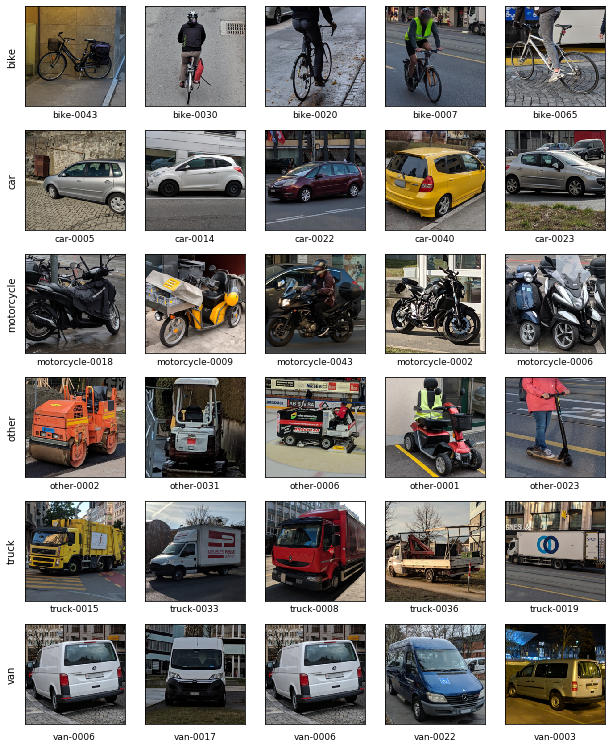

In [44]:
plot_samples(X_train, y_train, N_train, label_strs, random_state=RANDOM_SEED)

## Step 2: Make a scree plot<a name="step-2.2"></a> ([top](#top-2))
---

In [25]:
# 3rd party.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

We define a helper function to make a scree plot.

In [27]:
def plot_scree(pca: PCA,
               n_components: T.Optional[int] = None,
               figsize: T.Optional[T.Tuple[int, int]] = None) -> None:
    """\
    Makes a scree plot.

    Args:
        pca: A fitted PCA object.
        n_components: The optional number of principal components to include in the plot. If 
            omitted, defaults to the actual number of principal components.
        figsize: The optional size of the figure, as a tuple ``(width, height)`` (in inches). If 
            omitted, defaults to the default figure size (see 
            ``matplotlib.rcParams['figure.figsize']``).
    """
    n_components_total = len(pca.components_)
    n_components = n_components if n_components else n_components_total

    # Get the proportion of variance explained.
    pve = pca.explained_variance_ratio_[:n_components]

    # Create a bar plot.
    fig, ax = plt.subplots(figsize=figsize)
    xcor = np.arange(1, n_components + 1)  # 1, 2, ..., n_components
    ax.bar(xcor, pve, width = 0.6)  # Leave 40 % for padding.

    # Add the cumulative sum.
    pve_cumsum = np.cumsum(pve)
    ax.step(
        xcor + 0.5, # 1.5, 2.5, ..., (n_components + 0.5)
        pve_cumsum,
        label='cumulative'
    )

    # Add vertical lines.
    ax.vlines(xcor + 0.5, 0.0, pve_cumsum, linestyles='dotted', alpha=0.1)

    # Add labels, legend and tile.
    ax.set_xlabel('principal component')
    ax.set_ylabel('proportion of variance explained')
    ax.legend()
    fig.suptitle(f'Scree plot (principal components: {n_components}/{n_components_total}, '
                 f'PVE: {pve_cumsum[-1] * 100:.2f} %)', y=0.95)

    plt.show()

We define a helper function to plot the minimum number of principal components required to explain given ratios of variance.

In [29]:
def plot_number_of_components_required(pca: PCA, ratios: np.ndarray) -> None:
    """\
    Plots the minimum numbers of principal components required to explain given proportions of
    variance.
    
    Args:
        pca: A fitted PCA object.
        ratios: A list of proportions of variance.
    """
    pve = pca.explained_variance_ratio_
    
    # Make sure the ratios are sorted in ascending order.
    ratios = np.sort(ratios)

    # Get the minimum numbers of principal components required.
    pve_cumsum = np.cumsum(pve)
    npcrs = [(pve_cumsum > ratio).argmax() + 1 for ratio in ratios]
    
    # Most likely due to numerical errors, the cumulative sum does not reach exactly 1.0.
    if ratios[-1] == 1.0:
        npcrs[-1] = len(pca.components_)
    
    # Create a bar plot.
    fig, ax = plt.subplots()
    
    diffs = np.ediff1d(ratios)
    if len(diffs):
        width = diffs.min() * 0.60  # Leave 40 % for padding.
        ax.bar(ratios, npcrs, width=width)
    else:
        ax.bar(ratios, npcrs)

    # Annotate with the numbers of principal components required.
    for ratio, npcr in zip(ratios, npcrs):
        ax.annotate(f'{npcr:d}', xy=(ratio, npcr), rotation=0, color="black", ha='center', va='bottom')

    # Add a minor x-tick per ratio.
    ax.set_xticks(ratios, minor=False)
    
    # Add some vertical padding.
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - 10, ymax + 10)

    # Add labels.
    ax.set_xlabel('proportion of variance explained')
    ax.set_ylabel('number of principal components')
    fig.suptitle(f'Minimum number of principal components required\n'
                 f'to explain given proportions of variance', y=0.98)
    
    plt.show()

We apply PCA on the training set for both the high-level features and the images. We keep all components. In that case, $n_\textrm{components} = \min(n_\textrm{samples}, n_\textrm{features}) = 280$.

### Analysis for the high-level features

In [34]:
# Create a standard scaler.
scaler = StandardScaler()
# Rescale data.
F_train_rescaled = scaler.fit_transform(F_train)

# Create a PCA transformer.
F_train_pca_all = PCA(n_components=None,  # Keep all components.
                      random_state=RANDOM_SEED)  # Make it deterministic.
# Apply PCA to rescaled data.
F_train_pca_all.fit(F_train_rescaled);

We make plots for the high-level features. (We only include the first 150 principal components in the scree plot since the plot becomes hard to read otherwise.)

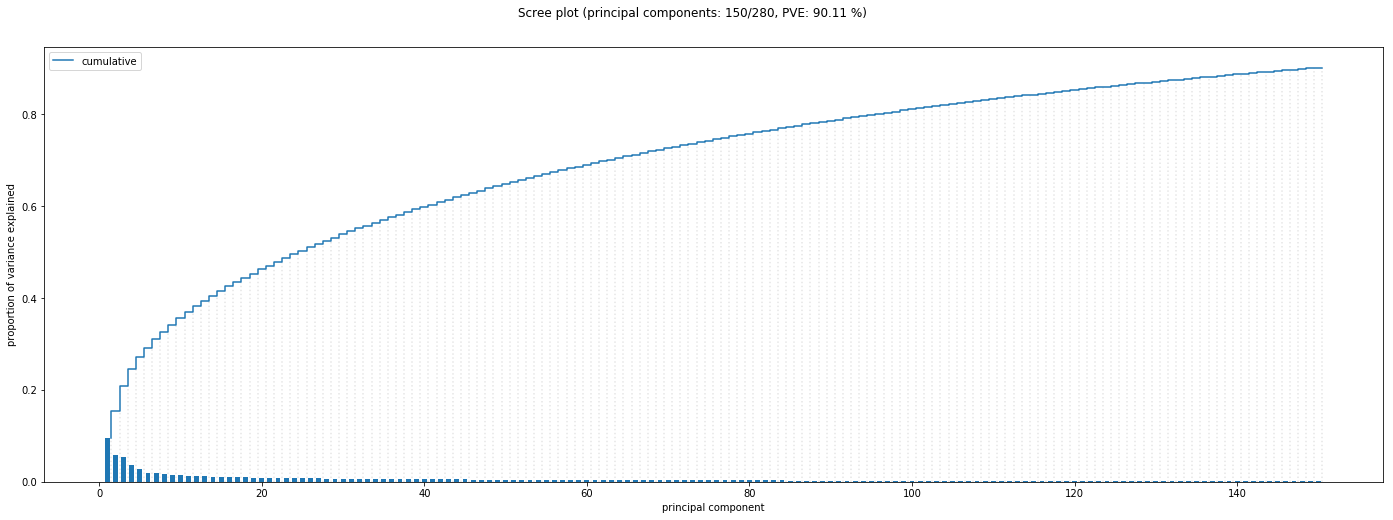

In [35]:
plot_scree(F_train_pca_all, 150, figsize=(24, 8))

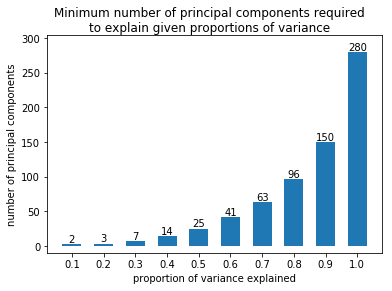

In [36]:
ratios = np.linspace(0.1, 1.0, num=10)  # 0.1, 0.2, ..., 1.0
plot_number_of_components_required(F_train_pca_all, ratios)

### Analysis for the images

In [37]:
# Reshape images as flat arrays.
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))

# Create a standard scaler.
scaler = StandardScaler()
# Rescale data.
X_train_rescaled = scaler.fit_transform(X_train_reshaped)

# Create a PCA transformer.
X_train_pca_all = PCA(n_components=None,  # Keep all components.
                      random_state=RANDOM_SEED)  # Make it deterministic.
# Apply PCA to rescaled data.
X_train_pca_all.fit(X_train_rescaled);

We make plots for the images. (Again, we only include the first 150 principal components in the scree plot since the plot becomes hard to read otherwise.)

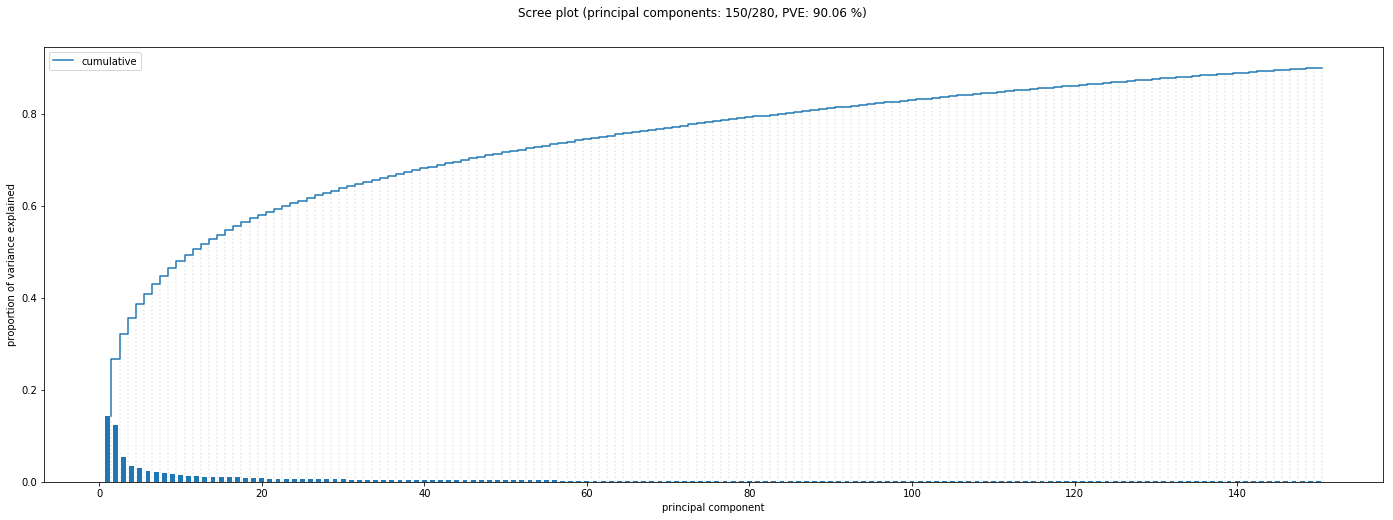

In [38]:
plot_scree(X_train_pca_all, 150, figsize=(24, 8))

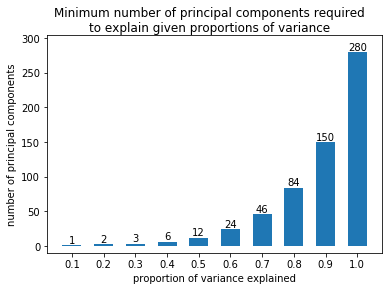

In [39]:
plot_number_of_components_required(X_train_pca_all, ratios)

**Comment:** The plots for the high-level features and for the images are very similar. So as far as PCA is concerned, the extracted high-level features seem to capture well the main features of the images.

## Step 3: Visualize the features on a 2D-plot<a name="step-2.3"></a> ([top](#top-2))
---

We create a PCA with only 2 components (the API does not seem to allow to drop all but the first 2 principal components from `F_pca_all`).

In [40]:
# Create a PCA transformer.
F_train_pca_2d = PCA(n_components=2,  # Keep the first 2 components.
                     random_state=RANDOM_SEED)  # Make it deterministic.
# Apply PCA to rescaled data.
F_train_2d = F_train_pca_2d.fit_transform(F_train_rescaled)

We define a helper function to make a 2D-plot. We know that the principal components form an orthonormal basis that spans the lower-dimensional space. To project a vector in feature space onto the lower-dimensional space we can simply take the dot product with each principal components. In particular, to project the $i$-th unit vector we can simply take the $i$-th component of each principal component.

In [41]:
def make_2d_plot(X_proj: np.ndarray, y: np.ndarray, label_strs: np.ndarray,
                 figsize: T.Optional[T.Tuple[int, int]] = None) -> None:
    """\
    Plots the projections of all data points onto the 2D space spanned by the first 2 principal
    components. These are orthonormal; we align the x-axis along the 1st one and the y-axis along
    the 2nd one.
    
    Args:
        X_proj: The data points transformed by PCA.
        y: The numeric labels of the data points.
        names: The unique text labels of the data points.
        figsize: The optional size of the figure, as a tuple ``(width, height)`` (in inches). If 
            omitted, defaults to the default figure size (see 
            ``matplotlib.rcParams['figure.figsize']``).
    """    
    # Create a plot.
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot projections of all samples in each category.
    for label in range(len(label_strs)):
        # Get the indices of samples that belong to this category.
        (idxs,) = np.nonzero(y == label)
        # Plot their components.
        ax.scatter(
            X_proj[idxs, 0],
            X_proj[idxs, 1],
            label=f'{label_strs[label]}'
        )

    # Add labels, legend and title.
    ax.set_xlabel('1st component')
    ax.set_ylabel('2nd component')
    ax.legend(bbox_to_anchor=(1.01,1), loc='upper left')
    fig.suptitle(f'PCA: projections by category', y=0.95)
    
    plt.show()

We make a 2D-plot.

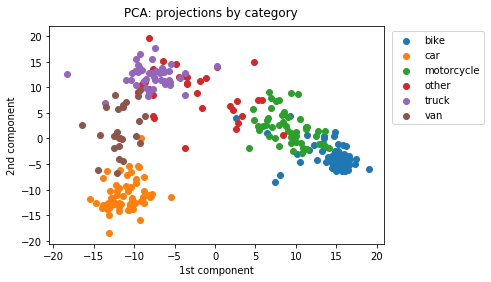

In [42]:
make_2d_plot(F_train_2d, y_train, label_strs)

**Comment:** Using the first 2 principal components, we can already "see" the 6 clusters corresponding the to the 6 categories. The cluster are not perfectly linearly separable and most pairs of clusters overlaps to some extent (e.g. *Car-Van*, *Van-Truck* and *Motorcycle-Bike*). Moreover, the *Other* cluter is very spread out and overlaps with many other clusters (e.g. *Van*, *Truck* and *Motorcyle*). This is kind of expected since the *Other* category contains different types of vehicles sometimes similar to the ones in other categories.